# Train Model

## Import Modules

In [0]:
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from scipy.io import loadmat, savemat
from sklearn.model_selection import KFold
import skimage.filters as filters
from skimage.transform import rescale

## Get a List of File Names of the Dataset


Assume that the dataset files we are looking for are of type 'mat'. Also assume that the image dataset is stored in the google drive in advance. You can put the dataset anywhere in the drive, but in our case, we put it in '/CS168-Automatic-TICI/data', where CS168-Automatic-TICI is the project repository.

In [2]:
BASE_DIR = os.getcwd()

# Mount the google drive to the virtue machine running this script.
# This will prompt for authorization.
DRIVE_MOUNT_DIR = os.path.join(os.getcwd(), 'drive')
drive.mount(DRIVE_MOUNT_DIR, force_remount=True)

Mounted at /content/drive


In [3]:
# Now the google drive can be accessed at 'DRIVE_MOUNT_DIR/My Drive'.
# Specify the directory to the data set.
REPOSITORY_NAME = 'CS168-Automatic-TICI'
REPOSITORY = os.path.join(DRIVE_MOUNT_DIR, 'My Drive', REPOSITORY_NAME)
DATA_DIR_NAME = 'feature_images'
DATA_DIR = os.path.join(REPOSITORY, DATA_DIR_NAME)

# Get a list of full paths of all mat files in the data directory.
for root, _dirs, files in os.walk(DATA_DIR):
    files = list(filter(lambda fname: fname.lower().endswith('.mat'), sorted(files)))
nfiles = len(files)
print('{} files found in the data directory \'{}\'.'.format(nfiles, DATA_DIR))

145 files found in the data directory '/content/drive/My Drive/CS168-Automatic-TICI/feature_images'.


## Read the Files, Extract Feature Images and TICIs
​
Each mat file contains an image set that represents the revascularization of a patient, and a TICI score. Read the files and output the image sets and TICI scores. Explore one of the image sets to get the image set dimensions.

In [4]:
images = []
TICIs = []


# TODO: put this part into a function to reduce RAM usage



# Extract the image set and TICI information for all mat files.
for n in range(nfiles):
    # Print the progress.
    if n % 10 == 0 or n == nfiles - 1:
        print('{} / {} done'.format(n, nfiles))
    content = loadmat(os.path.join(DATA_DIR, files[n]))
    image, TICI = content['image'], content['TICI']
    images.append(rescale(image, 1.0 / 4.0, anti_aliasing=True))
    TICIs.append(str(TICI[0]))
    
    
images = np.array(images)

0 / 145 done


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:23: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '


10 / 145 done
20 / 145 done
30 / 145 done
40 / 145 done
50 / 145 done
60 / 145 done
70 / 145 done
80 / 145 done
90 / 145 done
100 / 145 done
110 / 145 done
120 / 145 done
130 / 145 done
140 / 145 done
144 / 145 done


## Image Augmentation

In [0]:
# Image augmentation requires the ImageDataGenerator instance
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

In [0]:
def generate_augmented_dataset(original_images, TICIs, factor):
    l = len(original_images)
    print('Generating {} times augmented dataset for {} image(s)...'
          .format(factor, l))
    if l == 0:
        return [], []
    original_images = np.array(original_images)
    original_images = original_images.reshape(original_images.shape + (1,))

    count = 0
    augmented_images = []
    augmented_TICIs = []
    for batch_X, batch_y in datagen.flow(original_images,
                                         TICIs,
                                         batch_size=l):
        augmented_images.extend(batch_X)
        augmented_TICIs.extend(batch_y)      
        count += 1
        if count >= factor:
            print('{}00% image dataset generated for {} image(s).'
                  .format(factor, l))
            break  # otherwise the generator would loop indefinitely
    return np.array(augmented_images), np.array(augmented_TICIs)

Generating 9 times augmented dataset for 1 image(s)...
900% image dataset generated for 1 image(s).
['2a'] ['2a' '2a' '2a' '2a' '2a' '2a' '2a' '2a' '2a']


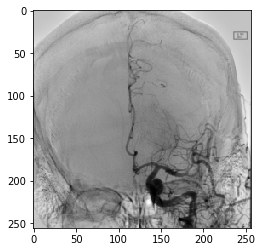

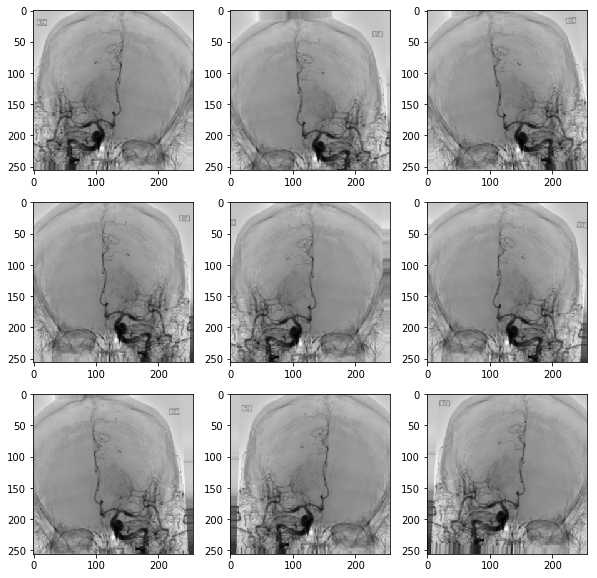

In [7]:
test_count = 0

test_images = [images[0]]
sample_TICIs = [TICIs[0]]

plt.figure()
plt.imshow(images[0], cmap='gray')


plt.figure(figsize=(10, 10))
test_aug_img, test_aug_TICIs = generate_augmented_dataset(test_images, sample_TICIs, 9)
print(sample_TICIs, test_aug_TICIs)
for i in range(len(test_aug_img)):
    plt.subplot(330 + 1 + i)
    h, w, _ = np.shape(test_aug_img[i])
    plt.imshow(test_aug_img[i].reshape(h,w), cmap='gray')

## Reformat TICI scores

In [8]:
# The number of different TICI scores.
# Including 0, 1, 2a, 2b, 3.
num_TICI_classes = 5

# Convert a TICI string to a number
def map_TICI_str_to_num(TICI):
    relation = {
        '0': 0,
        '1': 1,
        '2a': 2,
        '2b': 3,
        '3': 4,
        '0 (bilateral MCA)': 0,
        '2a?': 2
    }
    return relation[TICI]

# Convert a numerical encoded TICI to a string
def map_TICI_num_to_str(label):
    relation = ['0', '1', '2a', '2b', '3']
    return relation[label]



# Convert TICI scores in the form of strings to numeric labels before fed to the model.
TICI_nums = list(map(map_TICI_str_to_num, TICIs))

# Convert the array of integer labels (0 ~ num_TICI_classes-1) to an array of 
# one-hot (aka one-of-K) encoded labels, for better accuracy.
TICI_one_hot = tf.keras.utils.to_categorical(TICI_nums, num_TICI_classes)

print(np.shape(TICI_one_hot))

(145, 5)


## Train the Model

In [0]:
from tensorflow.keras import regularizers


def create_model():
    # Build the model with tensorflow.keras.
    # The general idea is to reduce the size by maxpooling and 
    # extract more features with convolutions of an increasing 
    # number of filters.
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, 5, padding='same', activation='relu',
                               input_shape=np.shape(images[0]) + (1,),
                               kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.MaxPooling2D(pool_size=(8, 8), strides=(8, 8), padding='same'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Conv2D(16, 5, padding='same', activation='relu',
                              kernel_regularizer=regularizers.l2(0.01)),
        tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(num_TICI_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01))
    ])

    model.summary()
    
    model.compile(
        loss=tf.keras.losses.categorical_crossentropy,
        optimizer='adam',
        metrics=['accuracy'])
    
    return model

In [0]:
BATCH_SIZE = 32
EPOCHS = 30
AUGMENTATION_FACTOR = 40


# K-fold cross validation
kf = KFold(n_splits=5)

for train_index, val_index in kf.split(images):
    x_train, x_val = images[train_index], images[val_index]
    y_train, y_val = TICI_one_hot[train_index], TICI_one_hot[val_index]
    x_val = x_val.reshape(x_val.shape + (1,))

    augmented_x_train, augmented_y_train = generate_augmented_dataset(
        x_train, y_train, AUGMENTATION_FACTOR)
    
    model = create_model()
    model.fit(
        x=augmented_x_train,
        y=augmented_y_train,
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=1,
        validation_data=(x_val, y_val)
    )
    
    loss, acc = model.evaluate(x_val, y_val)
    print('Model performance on the validation set -- loss: {} - acc: {}\n\n\n'
          .format(loss, acc))

Generating 40 times augmented dataset for 116 image(s)...
4000% image dataset generated for 116 image(s).
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 16)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 16)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        6416      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 16)  

In [0]:
# from keras.models import load_model


# REPOSITORY = os.path.join(DRIVE_MOUNT_DIR, 'My Drive', REPOSITORY_NAME)
# MODEL_DIR_NAME = 'models'
# MODEL_DIR = os.path.join(REPOSITORY, MODEL_DIR_NAME)

# !if test -d '$MODEL_DIR'; then rm -r '$MODEL_DIR'; fi
# !mkdir '$MODEL_DIR'


# model.save(os.path.join(MODEL_DIR, str(i) + '.h5'))


# # Returns a compiled model identical to the previous one
# model = load_model('my_model.h5')